In [1]:
import time
from Linear_sysmdl import SystemModel
from math import cos, sin, pi
import torch
from local_fit import LocalFitter, ExpWin_LS, ExpWin_DS, RectWin_LS, moving_avg, LCR, merge
import matplotlib.pyplot as plt
import torch.nn as nn
from param_lin import m1x_0, m2x_0
import pandas as pd

# range of 1/r^2 in dB
range_r_inv_dB = [-10, 0, 10, 20, 30]

# Tester

In [2]:
# number of traj
NB = 100



# time interval where the smoothing is valid
t_range = range(100, 900)
conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

# Y[idx_NB, idx_time]
def test_ma(NB, test_input, test_target, win):
    loss_func = nn.MSELoss(reduction='mean')
    MSEs = torch.empty(NB)

    start = time.time()
    for j in range(0, NB):
        y_j = test_input[j,:].unsqueeze(0)
        y = moving_avg(y_j, win)
        # ground truth of y_j: test_target[j,:]
        y_gt = test_target[j,:].unsqueeze(0)
        MSEs[j] = loss_func(y[:, t_range], y_gt[:, t_range])    
        MSE_avg = torch.mean(MSEs)
    MSE_avg_dB = 10*torch.log10(MSE_avg)
    print("Moving Average - MSE: ", MSE_avg_dB, " [dB]")
    print("Interence Time:", time.time()-start, " s")
    return [MSEs, MSE_avg, MSE_avg_dB] 

# Y[idx_NB, idx_time]
def test_local(NB, test_input, test_target, fitter, win_param_fwd, win_param_bwd, post_mult=conti_y):
    loss_func = nn.MSELoss(reduction='mean')
    MSEs = torch.empty(NB)
    start = time.time()
    for j in range(0, NB):
        y_j = test_input[j,:].unsqueeze(0)
        x = fitter.fit(y_j, win_param_fwd, win_param_bwd, post_mult)
        y = fitter.generate_signal()
        # ground truth of y_j: test_target[j,:]
        y_gt = test_target[j,:].unsqueeze(0)
        MSEs[j] = loss_func(y[:, t_range], y_gt[:, t_range])
    MSE_avg = torch.mean(MSEs)
    MSE_avg_dB = 10*torch.log10(MSE_avg)
    print("Local Method - MSE: ", MSE_avg_dB, " [dB]")
    print("Interence Time:", time.time()-start, " s")
    return [MSEs, MSE_avg, MSE_avg_dB] 

# Y[idx_NB, idx_time]
def test_local_fast_2Dline(NB, test_input, test_target, fitter, win_param_fwd, win_param_bwd, post_mult=conti_y):
    loss_func = nn.MSELoss(reduction='mean')
    MSEs = torch.empty(NB)
    start = time.time()
    for j in range(0, NB):
        y_j = test_input[j,:].unsqueeze(0)
        x = fitter.fit_fast_2Dline(y_j, win_param_fwd, win_param_bwd, post_mult)
        y = fitter.generate_signal()
        # ground truth of y_j: test_target[j,:]
        y_gt = test_target[j,:].unsqueeze(0)
        MSEs[j] = loss_func(y[:, t_range], y_gt[:, t_range])
    MSE_avg = torch.mean(MSEs)
    MSE_avg_dB = 10*torch.log10(MSE_avg)
    print("Local Method - MSE: ", MSE_avg_dB, " [dB]")
    print("Interence Time:", time.time()-start, " s")
    return [MSEs, MSE_avg, MSE_avg_dB]    

# Sinusoid Signal

In [13]:
T = 1000
period_sig = 100
amp = 10
omega = 2*pi/period_sig

## Test Local Method for NB(=100) Trajectories

### Generate 100 traj

In [159]:
A = torch.tensor([[cos(omega), -sin(omega)],
                    [sin(omega),  cos(omega)]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)

# ground truth
Y_gt = torch.empty([len(range_r_inv_dB), NB, T])
# noisy observations
Y_obs = torch.empty([len(range_r_inv_dB), NB, T])
for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    r = pow(10, -r_inv_dB/20)
    lssm = SystemModel(A, 0, C, r, T, T)
    lssm.InitSequence(m1x_0, m2x_0)
    lssm.GenerateBatch(NB, T)
    Y_obs[idx_r, :, :] = lssm.Observed.squeeze()

    lssm_ideal = SystemModel(A, 0, C, 0, T, T)
    lssm_ideal.InitSequence(m1x_0, m2x_0)
    lssm_ideal.GenerateBatch(NB, T)
    Y_gt[idx_r, :, :] = lssm_ideal.Observed.squeeze()


In [160]:
torch.save(Y_gt, 'test_local/sin/Y_gt.pt')
torch.save(Y_obs, 'test_local/sin/Y_obs.pt')

### Start testing

1. moving average
2. local fitting of sinsuoid
3. local fitting of line

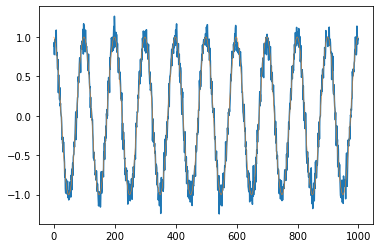

In [220]:
Y_obs = torch.load('test_local/sin/Y_obs.pt')
Y_gt = torch.load('test_local/sin/Y_gt.pt')

plt.plot(torch.arange(0,T), Y_obs[3,0,:])
plt.plot(torch.arange(0,T), Y_gt[3,0,:], linewidth='0.5')

In [221]:
MSEs_ma_dB = torch.empty(len(range_r_inv_dB))
std_MSE_ma_dB = torch.empty(len(range_r_inv_dB))
MSEs_LF_sin_dB = torch.empty(len(range_r_inv_dB))
std_MSE_LF_sin_dB = torch.empty(len(range_r_inv_dB))
MSEs_LF_line_dB = torch.empty(len(range_r_inv_dB))
std_MSE_LF_line_dB = torch.empty(len(range_r_inv_dB))

opath = 'test_local/sin/'

# param for local sin method
omega_prior = 2*pi/100
A_sin = torch.tensor([[cos(omega_prior), -sin(omega_prior)],
                    [sin(omega_prior),  cos(omega_prior)]])
C_sin = torch.tensor([1.0, 0.0]).unsqueeze(0)
local_model_sin = LocalFitter(A_sin, C_sin, ExpWin_DS(), A_sin, C_sin)

# param for local line method
A_line = torch.tensor([[1.0, 1.0],
                       [0.0, 1.0]])
C_line = torch.tensor([1.0, 0.0]).unsqueeze(0)
local_model_line = LocalFitter(A_line, C_sin, ExpWin_DS(), A_line, C_sin)



In [222]:
gamma = 0.999
for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    ## moving avg
    MSEs, mean_MSE, MSEs_ma_dB[idx_r] = test_ma(NB, test_input=Y_obs[idx_r,:,:], test_target=Y_gt[idx_r,:,:], win=10)
    std_MSE = torch.std(MSEs)
    std_MSE_ma_dB[idx_r] = 10*torch.log10(mean_MSE+std_MSE) - MSEs_ma_dB[idx_r]



Moving Average - MSE:  tensor(-3.30211)  [dB]
Interence Time: 0.813683032989502  s
Moving Average - MSE:  tensor(-13.00744)  [dB]
Interence Time: 0.8119502067565918  s
Moving Average - MSE:  tensor(-21.34604)  [dB]
Interence Time: 0.8222630023956299  s
Moving Average - MSE:  tensor(-25.15440)  [dB]
Interence Time: 0.8106670379638672  s
Moving Average - MSE:  tensor(-25.94223)  [dB]
Interence Time: 0.8095710277557373  s


In [223]:
gamma = 0.999
for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    ## LF sin
    MSEs, mean_MSE, MSEs_LF_sin_dB[idx_r] = test_local(NB, Y_obs[idx_r,:,:], Y_gt[idx_r,:,:], local_model_sin, gamma, gamma)
    std_MSE = torch.std(MSEs)
    std_MSE_LF_sin_dB[idx_r] = 10*torch.log10(mean_MSE+std_MSE) - MSEs_LF_sin_dB[idx_r]



Local Method - MSE:  tensor(-17.23795)  [dB]
Interence Time: 12.447435140609741  s
Local Method - MSE:  tensor(-26.45109)  [dB]
Interence Time: 12.342880010604858  s
Local Method - MSE:  tensor(-36.39767)  [dB]
Interence Time: 12.411402940750122  s
Local Method - MSE:  tensor(-46.26324)  [dB]
Interence Time: 12.55665111541748  s
Local Method - MSE:  tensor(-56.91892)  [dB]
Interence Time: 12.526082038879395  s


In [11]:
gamma = 0.94
L = 10
for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    ## LF line
    MSEs, mean_MSE, MSEs_LF_line_dB[idx_r] = test_local(NB, Y_obs[idx_r,:,:], Y_gt[idx_r,:,:], local_model_line, win_param_fwd=gamma, win_param_bwd=gamma)
    std_MSE = torch.std(MSEs)
    std_MSE_LF_line_dB[idx_r] = 10*torch.log10(mean_MSE+std_MSE) - MSEs_LF_line_dB[idx_r]




Local Method - MSE:  tensor(-4.2541)  [dB]
Interence Time: 12.977016925811768  s
Local Method - MSE:  tensor(-14.1721)  [dB]
Interence Time: 13.124142169952393  s
Local Method - MSE:  tensor(-23.9902)  [dB]
Interence Time: 13.12106704711914  s
Local Method - MSE:  tensor(-33.6321)  [dB]
Interence Time: 12.970710039138794  s
Local Method - MSE:  tensor(-41.7063)  [dB]
Interence Time: 12.879863977432251  s


In [12]:
print('Noise Floor: ', range_r_inv_dB)
print('Moving Avergae', MSEs_ma_dB)
print('LF sin:', MSEs_LF_sin_dB)
print('LF line:', MSEs_LF_line_dB)


Noise Floor:  [-10, 0, 10, 20, 30]
Moving Avergae tensor([ -3.3021, -13.0074, -21.3460, -25.1544, -25.9422])
LF sin: tensor([-17.2379, -26.4511, -36.3977, -46.2632, -56.9189])
LF line: tensor([ -4.2541, -14.1721, -23.9902, -33.6321, -41.7063])


In [13]:
torch.save(MSEs_ma_dB,          opath+'MSEs_ma.pt')
torch.save(std_MSE_ma_dB,       opath+'std_MSE_ma.pt')
torch.save(MSEs_LF_sin_dB,      opath+'MSEs_LF_sin.pt')
torch.save(std_MSE_LF_sin_dB,   opath+'std_MSE_LF_sin.pt')
torch.save(MSEs_LF_line_dB,     opath+'MSEs_LF_line.pt')
torch.save(std_MSE_LF_line_dB,  opath+'std_MSE_LF_line.pt')

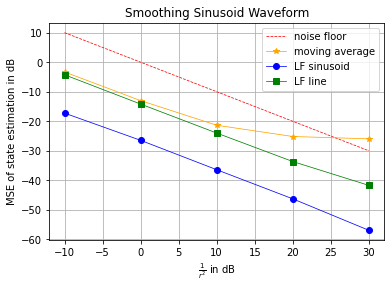

In [11]:
ipath = 'test_local/sin/'

MSEs_ma_dB = torch.load(ipath+'MSEs_ma.pt')
MSEs_LF_sin_dB = torch.load(ipath+'MSEs_LF_sin.pt')
MSEs_LF_line_dB = torch.load(ipath+'MSEs_LF_line.pt')

plt.figure()
plt.title('Smoothing Sinusoid Waveform')
plt.xlabel(r'$\frac{1}{r^2}$ in dB')
plt.ylabel('MSE of state estimation in dB')
plt.plot(range_r_inv_dB, [ -x for x in range_r_inv_dB], '--', color='red', linewidth='0.75', label='noise floor')
plt.plot(range_r_inv_dB, MSEs_ma_dB, '*-', color='orange', linewidth='0.75', label='moving average')
plt.plot(range_r_inv_dB, MSEs_LF_sin_dB, 'o-', color='blue', linewidth='0.75', label='LF sinusoid')
plt.plot(range_r_inv_dB, MSEs_LF_line_dB, 's-', color='green', linewidth='0.75', label='LF line')
plt.legend()
plt.grid()
plt.savefig('test_local/sin/MSE.pdf')

In [ ]:
print('ma:')
print(MSEs_ma_dB)
print(std_MSE_ma_dB)

print('LF:')
print(MSEs_LF_sin_dB)
print(std_MSE_LF_sin_dB)

ma:
tensor([ -3.2567, -13.0101, -21.4191, -25.1975, -25.9022])
tensor([0.7395, 0.8257, 0.7682, 0.4939, 0.2091])
LF:
tensor([-16.8070, -26.6329, -35.2541, -39.4917, -40.2735])
tensor([3.1876, 2.9890, 2.3081, 0.9555, 0.1682])


### Export table

In [15]:

################################################
####### Export data for state estimation #######
################################################
def export_table(MSEs, stds, row_name=None, col_name=None):
    if len(MSEs.size())==1:
        MSEs = MSEs.unsqueeze(0)
    if len(stds.size())==1:
        stds = stds.unsqueeze(0)
    table_mean = pd.DataFrame(MSEs.numpy())
    table_std = pd.DataFrame(stds.numpy())        
    table_mean_and_std = pd.concat([table_mean, table_std]).sort_index(axis=0)
    if(col_name is not None):
        table_mean_and_std.columns = col_name
    if (row_name is not None):
        table_mean_and_std.index = row_name
    return table_mean_and_std



In [16]:

MSEs_ma_dB = torch.load('test_local/sin/MSEs_ma.pt')
std_MSE_ma = torch.load('test_local/sin/std_MSE_ma.pt')
MSEs_LF_sin_dB = torch.load('test_local/sin/MSEs_LF_sin.pt')
std_MSE_LF_sin_dB = torch.load('test_local/sin/std_MSE_LF_sin.pt')
MSEs_LF_line_dB = torch.load('test_local/sin/MSEs_LF_line.pt')
std_MSE_LF_line_dB = torch.load('test_local/sin/std_MSE_LF_line.pt')

In [ ]:
cols = ['r^-2=-10 dB', 'r^-2=0 dB', 'r^-2=10 dB', 'r^-2=20 dB', 'r^-2=30 dB']
rows = ['$\hat \mu$', '$\hat \sigma$']
table_ma = export_table(MSEs_ma_dB, std_MSE_ma, row_name=rows, col_name=cols).round(2)
table_LF_sin = export_table(MSEs_LF_sin_dB, std_MSE_LF_sin_dB, row_name=rows, col_name=cols).round(2)
table_LF_line = export_table(MSEs_LF_line_dB, std_MSE_LF_line_dB, row_name=rows, col_name=cols).round(2)

table_ma.to_csv('test_local/sin/MSE_ma.csv')
table_LF_sin.to_csv('test_local/sin/MSE_LF.csv')
table_LF_line.to_csv('test_local/sin/MSE_line.csv')


In [ ]:
table_LF_sin

,r^-2=-10 dB,r^-2=0 dB,r^-2=10 dB,r^-2=20 dB,r^-2=30 dB
$\hat \mu$,-16.809999,-26.629999,-35.25,-39.490002,-40.27
$\hat \sigma$,3.190000,2.990000,2.31,0.960000,0.17


In [ ]:
table_LF_line

,r^-2=-10 dB,r^-2=0 dB,r^-2=10 dB,r^-2=20 dB,r^-2=30 dB
$\hat \mu$,-1.73,-11.34,-18.4,-20.870001,-21.129999
$\hat \sigma$,0.69,0.75,0.7,0.350000,0.140000


### Test export table 

In [ ]:
MSEs_baseline = torch.load('Data_baseline/MSE_state_baseline.pt')
std_MSEs_baseline = torch.load('Data_baseline/std_MSE_state_baseline.pt')
print(MSEs_baseline)
print(std_MSEs_baseline)

tensor([[  6.2136,  -3.7970, -13.7886, -23.7886, -33.8117],
        [  1.8197,  -8.1750, -18.1683, -28.1716, -38.1601],
        [ -1.8295, -11.8320, -21.8481, -31.8634, -41.8163]])
tensor([[0.5016, 0.4783, 0.5008, 0.4818, 0.4880],
        [0.7588, 0.7691, 0.7808, 0.7997, 0.8000],
        [1.1965, 1.1916, 1.2418, 1.2440, 1.1791]])


In [ ]:
hori_header = ['r^-2=-10 dB', 'r^-2=0 dB', 'r^-2=10 dB', 'r^-2=20 dB', 'r^-2=30 dB']
vert_header = pd.MultiIndex.from_product([['$q^2/r^2$=0dB','$q^2/r^2$=-10dB', '$q^2/r^2$=-20dB'],
                                          ['$\hat \mu$', '$\hat \sigma$']],
                                          names=['nu','moment_MSE']) 
table_baseline = export_table(MSEs_baseline, std_MSEs_baseline, vert_header, hori_header).astype(float).round(2)

table_baseline.index = vert_header
print(table_baseline)
table_baseline.to_csv('~/Desktop/MSE_state.csv')

                               r^-2=-10 dB  r^-2=0 dB  r^-2=10 dB  r^-2=20 dB  \
nu              moment_MSE                                                      
$q^2/r^2$=0dB   $\hat \mu$            6.21      -3.80      -13.79      -23.79   
                $\hat \sigma$         0.50       0.48        0.50        0.48   
$q^2/r^2$=-10dB $\hat \mu$            1.82      -8.17      -18.17      -28.17   
                $\hat \sigma$         0.76       0.77        0.78        0.80   
$q^2/r^2$=-20dB $\hat \mu$           -1.83     -11.83      -21.85      -31.86   
                $\hat \sigma$         1.20       1.19        1.24        1.24   

                               r^-2=30 dB  
nu              moment_MSE                 
$q^2/r^2$=0dB   $\hat \mu$         -33.81  
                $\hat \sigma$        0.49  
$q^2/r^2$=-10dB $\hat \mu$         -38.16  
                $\hat \sigma$        0.80  
$q^2/r^2$=-20dB $\hat \mu$         -41.82  
                $\hat \sigma$        1.18  

## Test Local Method for one trajectory

In [14]:
omega_t = omega*torch.arange(0, T) + pi/2
y_sin = amp*torch.sin(omega_t)
y_sin = y_sin.unsqueeze(0)
r = 5.0
e = torch.normal(mean=torch.zeros([1, T]), std=r*torch.ones([1, T]))
y_sin_noisy = y_sin + e

###  Moving Average

In [15]:
y_sin_MA = moving_avg(y_sin_noisy, win=5)

### LF sinusoid (Double Sided)

In [16]:
gamma = 0.999
omega_prior = 2*pi/100
A_sin = torch.tensor([[cos(omega_prior), -sin(omega_prior)],
                    [sin(omega_prior),  cos(omega_prior)]])
C_sin = torch.tensor([1.0, 0.0]).unsqueeze(0)
pm_conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

sin_model = LocalFitter(A_sin, C_sin, ExpWin_DS(), A_sin, C_sin)
sin_model.fit(y_sin_noisy, win_param_fwd = gamma, win_param_bwd = gamma, post_mult=pm_conti_y)
y_sin_LF_sin = sin_model.generate_signal()

### LF line (Doubel Sided)

In [17]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)

split_linear_model = LocalFitter(A, C, ExpWin_DS(), A, C)

# gamma = 0.975 is a sweet spot!
gamma = 0.935

conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

split_linear_model.fit(y_sin_noisy, 
                       win_param_fwd=gamma, 
                       win_param_bwd=gamma, 
                       post_mult=conti_y)             

y_sin_LF_split_linear = split_linear_model.generate_signal()

Plot

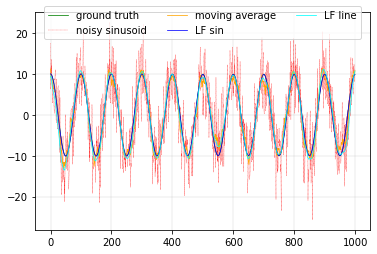

In [32]:
plt.figure()
plt.plot(torch.arange(0, T), y_sin.squeeze(), color='green', linewidth=0.75, label='ground truth')
plt.plot(torch.arange(0, T), y_sin_noisy.squeeze(), '--', color='red', linewidth=0.25, label='noisy sinusoid')
plt.plot(torch.arange(0, T), y_sin_MA.squeeze(), color='orange', linewidth=0.75, label='moving average')
plt.plot(torch.arange(0, T), y_sin_LF_sin.squeeze(), color='blue', linewidth=0.75, label='LF sin')
plt.plot(torch.arange(0, T), y_sin_LF_split_linear.squeeze(), color='cyan', linewidth=0.75, label='LF line')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=False)
plt.grid(lw=0.25)

plt.savefig('test_local/sin/sinusoid.pdf')
plt.show()



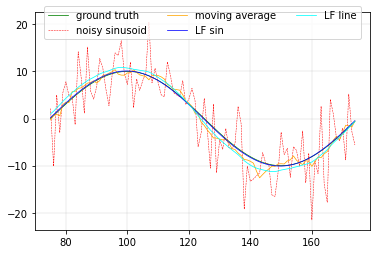

In [34]:
start, end = 75, 175
plt.figure()
plt.plot(torch.arange(start, end), y_sin.squeeze()[start:end], color='green', linewidth=0.75, label='ground truth')
plt.plot(torch.arange(start, end), y_sin_noisy.squeeze()[start:end], '--', color='red', linewidth=0.5, label='noisy sinusoid')
plt.plot(torch.arange(start, end), y_sin_MA.squeeze()[start:end], color='orange', linewidth=0.75, label='moving average')
plt.plot(torch.arange(start, end), y_sin_LF_sin.squeeze()[start:end], color='blue', linewidth=0.75, label='LF sin')
plt.plot(torch.arange(start, end), y_sin_LF_split_linear.squeeze()[start:end], color='cyan', linewidth=0.75, label='LF line')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=False)
plt.grid(lw=0.25)

plt.savefig('test_local/sin/sinusoid_zoom.pdf')
plt.show()

In [34]:
loss_func = nn.MSELoss(reduction='mean')
t_range = range(100, 800)
MSE_MA = loss_func(y_sin[:, t_range], y_sin_MA[:, t_range])
MSE_LF_sin = loss_func(y_sin[:, t_range], y_sin_LF_sin[:, t_range])
MSE_LF_lin = loss_func(y_sin[:, t_range], y_sin_LF_split_linear[:, t_range])
MSE_MA = 10*torch.log10(MSE_MA)
MSE_LF_sin = 10*torch.log10(MSE_LF_sin)
MSE_LF_lin = 10*torch.log10(MSE_LF_lin)
print('Noise Floor:', 10*torch.log10(torch.tensor(r**2)), '[dB]')
print('MSE - Moving Avg: ',  MSE_MA, '[dB]')
print('MSE - LF sin: ',  MSE_LF_sin, '[dB]')
print('MSE - LF line: ', MSE_LF_lin, '[dB]')

Noise Floor: tensor(13.9794) [dB]
MSE - Moving Avg:  tensor(3.4098) [dB]
MSE - LF sin:  tensor(-20.7893) [dB]
MSE - LF line:  tensor(-0.2499) [dB]


# Line

### Generate noisy linear function

In [ ]:
T = 1000
slope = 0.05
offset = 1.0
y_lin = slope*torch.arange(0, T) + offset
y_lin = y_lin.unsqueeze(0)
e = torch.normal(mean=torch.zeros([1, T]), std=5.0*torch.ones([1, T]))
y_lin_obs = y_lin + e

### Apply Moving Average

In [ ]:
y_MA = moving_avg(y_lin_obs, win=5)

### Fit LSSM to noisy linear

In [ ]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)

# rect win
# gamma = 1-1e-4
# win_len = 200
# x = model.fit(y_lin_obs, [gamma, win_len])
# y_LF_rectwin = model.generate_signal()

# exp win
model = LocalFitter(torch.inverse(A), C, ExpWin_DS(), A, C)
gamma = 1-1e-2
continuous_constraint = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [0.0, 1.0]
])
x = model.fit(y_lin_obs, win_param_fwd=gamma, win_param_bwd=gamma, post_mult=continuous_constraint)
y_LF_expwin = model.generate_signal()

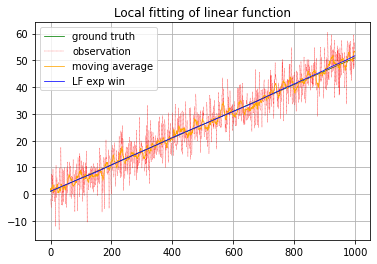

In [ ]:
plt.figure()
plt.title('Local fitting of linear function')
plt.plot(torch.arange(0, T), y_lin.squeeze(), color='green',  linewidth=0.75, label='ground truth')
plt.plot(torch.arange(0, T), y_lin_obs.squeeze(), '--', color='red',  linewidth=0.25, label='observation')
plt.plot(torch.arange(0, T), y_MA.squeeze(), color='orange', linewidth=0.75, label='moving average')
plt.plot(torch.arange(0, T), y_LF_expwin.squeeze(), color='blue', linewidth=0.75, label='LF exp win')
plt.legend()
plt.grid()

plt.savefig('test_local/line.pdf')
plt.show()

In [ ]:
t_range = range(200, 800)
loss_func = nn.MSELoss(reduction='mean')
print('MSE - Noise Floor: ', loss_func(y_lin[:, t_range], y_lin_obs[:, t_range]))
print('MSE - Moving Avg: ', loss_func(y_lin[:, t_range], y_MA[:, t_range]))
print('MSE - LF exp win: ', loss_func(y_lin[:, t_range], y_LF_expwin[:, t_range]))

MSE - Noise Floor:  tensor(25.8227)
MSE - Moving Avg:  tensor(2.4318)
MSE - LF exp win:  tensor(0.0138)


# Triangular Waveform

## Test for 100 trajectory

### Generate signals

In [222]:
# number of traj
NB = 100

# range of 1/r^2 in dB
range_r_inv_dB = [-10, 0, 10, 20, 30]

# length of each traj
T = 1000

# param for triangular waveform
low, high = 0.0, 10.0
period_tri = 100
y_left = torch.linspace(start=low, end=high, steps=int(period_tri/2))
y_right = torch.linspace(start=high, end=low, steps=int(period_tri/2))
y_tri = torch.cat([y_left, y_right]).repeat(int(T/period_tri))


# ground truth
Y_gt = y_tri.repeat(len(range_r_inv_dB), NB, 1)

# noisy observations
Y_obs = torch.empty([len(range_r_inv_dB), NB, T])
for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    r = pow(10, -r_inv_dB/20)
    e = torch.normal(mean=torch.zeros([NB, T]), std=r*torch.ones([1, T]))
    Y_obs[idx_r, :, :] = Y_gt[idx_r, :, :] + e

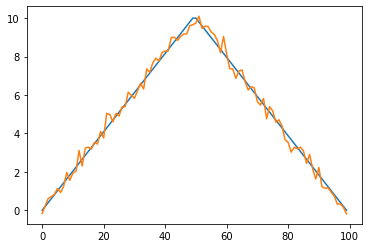

In [223]:
plt.plot(Y_gt[2,0,0:100])
plt.plot(Y_obs[2,0,0:100])

In [224]:
opath = 'test_local/tri/'
torch.save(Y_gt, opath+'Y_gt.pt')
torch.save(Y_obs, opath+'Y_obs.pt')

### Start testing
1. moving average
2. local fit split linear model

In [3]:
ipath = 'test_local/tri/'
Y_obs = torch.load(ipath+'Y_obs.pt')
Y_gt = torch.load(ipath+'Y_gt.pt')

MSEs_ma_dB = torch.empty(len(range_r_inv_dB))
std_MSE_ma_dB = torch.empty(len(range_r_inv_dB))
MSEs_LF_line_dB = torch.empty(len(range_r_inv_dB))
std_MSE_LF_line_dB = torch.empty(len(range_r_inv_dB))

opath = 'test_local/sin/'

Moving average

In [4]:
for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    ## moving avg
    MSEs, mean_MSE, MSEs_ma_dB[idx_r] = test_ma(NB, test_input=Y_obs[idx_r,:,:], test_target=Y_gt[idx_r,:,:], win=10)
    std_MSE = torch.std(MSEs)
    std_MSE_ma_dB[idx_r] = 10*torch.log10(mean_MSE+std_MSE) - MSEs_ma_dB[idx_r]



Moving Average - MSE:  tensor(-2.2779)  [dB]
Interence Time: 0.7542691230773926  s
Moving Average - MSE:  tensor(-8.4243)  [dB]
Interence Time: 0.7430331707000732  s
Moving Average - MSE:  tensor(-9.9548)  [dB]
Interence Time: 0.752485990524292  s
Moving Average - MSE:  tensor(-10.1634)  [dB]
Interence Time: 0.7485711574554443  s
Moving Average - MSE:  tensor(-10.1910)  [dB]
Interence Time: 0.7372057437896729  s


In [5]:
opath = 'test_local/tri/'
torch.save(MSEs_ma_dB,          opath+'MSEs_ma_dB.pt')
torch.save(std_MSE_ma_dB,       opath+'std_MSE_ma_dB.pt')

Local model fit

In [5]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)

split_linear_model = LocalFitter(A, C, ExpWin_DS(), A, C)

# gamma = 0.975 is a sweet spot!
gammas = [0.945, 0.935, 0.71, 0.65, 0.4]

conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

for idx_r, r_inv_dB in enumerate(range_r_inv_dB):
    ## LF line
    MSEs, mean_MSE, MSEs_LF_line_dB[idx_r] = test_local_fast_2Dline(NB, Y_obs[idx_r,:,:], Y_gt[idx_r,:,:], split_linear_model, win_param_fwd=gammas[idx_r], win_param_bwd=gammas[idx_r])
    std_MSE = torch.std(MSEs)
    std_MSE_LF_line_dB[idx_r] = 10*torch.log10(mean_MSE+std_MSE) - MSEs_LF_line_dB[idx_r]




Local Method - MSE:  tensor(-2.9250)  [dB]
Interence Time: 9.604423999786377  s
Local Method - MSE:  tensor(-8.8321)  [dB]
Interence Time: 9.673846006393433  s
Local Method - MSE:  tensor(-3.3758)  [dB]
Interence Time: 9.708590269088745  s
Local Method - MSE:  tensor(-2.1681)  [dB]
Interence Time: 9.673404932022095  s
Local Method - MSE:  tensor(-0.0805)  [dB]
Interence Time: 9.748842000961304  s


In [233]:
opath = 'test_local/tri/'
torch.save(MSEs_LF_line_dB,     opath+'MSEs_LF_line_dB.pt')
torch.save(std_MSE_LF_line_dB,  opath+'std_MSE_LF_line_dB.pt')

In [6]:
print('Noise Floor: ', range_r_inv_dB)
print('Moving Avergae', MSEs_ma_dB)
print('LF line:', MSEs_LF_line_dB)

Noise Floor:  [-10, 0, 10, 20, 30]
Moving Avergae tensor([ -2.2779,  -8.4243,  -9.9548, -10.1634, -10.1910])
LF line: tensor([-2.9250, -8.8321, -3.3758, -2.1681, -0.0805])


### Plots

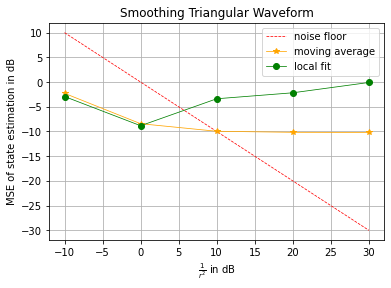

In [7]:
plt.figure()
plt.title('Smoothing Triangular Waveform')
plt.xlabel(r'$\frac{1}{r^2}$ in dB')
plt.ylabel('MSE of state estimation in dB')
plt.plot(range_r_inv_dB, [ -x for x in range_r_inv_dB], '--', color='red', linewidth='0.75', label='noise floor')
plt.plot(range_r_inv_dB, MSEs_ma_dB, '*-', color='orange', linewidth='0.75', label='moving average')
plt.plot(range_r_inv_dB, MSEs_LF_line_dB, 'o-', color='green', linewidth='0.75', label='local fit')
plt.legend()
plt.grid()


In [ ]:
plt.savefig('test_local/tri/MSE.pdf')

## Test for one trajectory
 
- $x_t$: triangular waveform.
- $y_t = x_t + v_t$ where $v_t\sim \mathcal{N}(0, r^2)$ 
- Period of $x_t$: 100 samples.

|       Noise Index            |   0   |   1   |   2  |  3   |   4  | 
|------------------------------|-----  |  ---  |----  |----  |----  |
| **$\frac{1}{r^2}$ [dB]**     | -10   |   0   |  10  |  20  |  30  |
| **$\gamma$ (linear scaling)**| 0.945 | 0.935 | 0.71 | 0.65 |  0.4 |
| **MSE [dB]**                 | -4.05  | -9.61 |-15.44|-21,26|-31.12|




### Signal Generation

In [4]:
T = 1000
slope_left = 0.05
offset = 1.0
y_tri_l = slope_left*torch.arange(0, T/2) + offset
y_tri_r = torch.flip(y_tri_l, [0])
y_tri = torch.cat((y_tri_l, y_tri_r), 0)

sigma = 2.0
e = torch.normal(mean=torch.zeros([1, T]), std=sigma*torch.ones([1, T]))
y_tri_noisy = y_tri + e


In [5]:
Y_gt = torch.load('test_local/tri/Y_gt.pt')
Y_obs = torch.load('test_local/tri/Y_obs.pt')


In [209]:
nl = 0
y_tri = Y_gt[nl,0,:].unsqueeze(0)
y_tri_noisy = Y_obs[nl,0,:].unsqueeze(0)

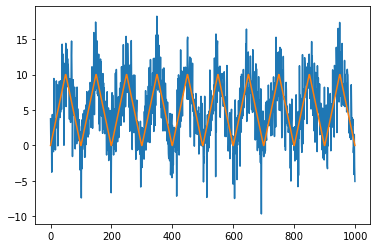

In [210]:
plt.plot(range(0, T), y_tri_noisy.squeeze())
plt.plot(range(0, T), y_tri.squeeze())

### Apply MA on one trajectory

In [211]:
y_tri_MA = moving_avg(y_tri_noisy, win=5)

### Local Fitting on one trajectory
1. Continuous Linear Model
2. Split Linear Model

In [212]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)


linear_model = LocalFitter(torch.inverse(A), C, ExpWin_DS(), A, C)
split_linear_model = LocalFitter(A, C, ExpWin_DS(), A, C)

# gamma = 0.975 is a sweet spot!
gamma = 0.945

conti_x = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [0.0, 1.0]
])

conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

linear_model.fit(y_tri_noisy, 
                win_param_fwd=gamma, 
                win_param_bwd=gamma, 
                post_mult=conti_x)

split_linear_model.fit(y_tri_noisy, 
                       win_param_fwd=gamma, 
                       win_param_bwd=gamma, 
                       post_mult=conti_y)             

y_tri_LF_conti_linear = linear_model.generate_signal()
y_tri_LF_split_linear = split_linear_model.generate_signal()


### Plot

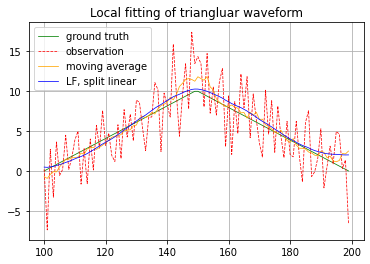

In [213]:
plt.figure()
plt.title('Local fitting of triangluar waveform')
start = 100
end = 200
plt.plot(torch.arange(start, end), y_tri[0, start:end], color='green',  linewidth=0.75, label='ground truth')
plt.plot(torch.arange(start, end), y_tri_noisy[0, start:end], '--', color='red',  linewidth=0.75, label='observation')
plt.plot(torch.arange(start, end), y_tri_MA[0, start:end], color='orange', linewidth=0.75, label='moving average')
plt.plot(torch.arange(start, end), y_tri_LF_split_linear[0, start:end], color='blue', linewidth=0.75, label='LF, split linear')
plt.legend()
plt.grid()

# plt.savefig('test_local/tri_wave_period.pdf')
plt.show()

### Evaluation

In [214]:
t_range = range(100, 900)
loss_func = nn.MSELoss(reduction='mean')
torch.set_printoptions(precision=5, sci_mode=False)
y_gt = y_tri

MSE_noise_floor = loss_func(y_gt[:, t_range], y_tri_noisy[:, t_range])
MSE_ma = loss_func(y_gt[:, t_range], y_tri_MA[:, t_range])
MSE_LF_split_linear = loss_func(y_gt[:, t_range], y_tri_LF_split_linear[:, t_range])

MSE_noise_floor = 10*torch.log10(MSE_noise_floor)
MSE_ma = 10*torch.log10(MSE_ma)
MSE_LF_split_linear = 10*torch.log10(MSE_LF_split_linear)

print('MSE - Noise Floor: ', MSE_noise_floor, '[dB]')
print('MSE - Moving Average: ', MSE_ma, '[dB]')
print('MSE - LF split linear model: ', MSE_LF_split_linear, '[dB]')


MSE - Noise Floor:  tensor(10.15498) [dB]
MSE - Moving Average:  tensor(-1.05967) [dB]
MSE - LF split linear model:  tensor(-4.05063) [dB]


### Local Cost Ratio (LCR)

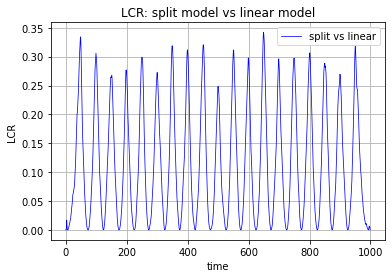

In [26]:
lcr = LCR(split_linear_model, linear_model)
plt.figure()
plt.title('LCR: split model vs linear model')
plt.xlabel('time')
plt.ylabel('LCR')
plt.plot(torch.arange(0, T), lcr.squeeze(), color='blue',  linewidth=0.75, label='split vs linear')
plt.legend()
plt.grid()

plt.show()

# Rectangular Waveform

### Signal Generation

In [ ]:
T = 1000
level_l = 10.0
level_r = -5.0
y_rect_l = level_l*torch.ones(1, int(T/2))
y_rect_r = level_r*torch.ones(1, int(T/2))
y_rect = torch.cat((y_rect_l, y_rect_r), dim=1)

sigma = 2.0
e = torch.normal(mean=torch.zeros([1, T]), std=sigma*torch.ones([1, T]))
y_rect_noisy = y_rect + e


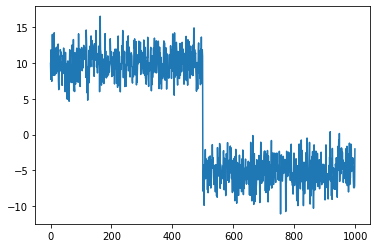

In [ ]:
plt.plot(range(0, T), y_rect_noisy.squeeze())

### Apply Moving Average

In [ ]:
y_rect_MA = moving_avg(y_rect_noisy, win=5)

### Local Fitting LSSM
1. Continuous Linear Model
2. Split DC Model

In [ ]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)


linear_model = LocalFitter(torch.inverse(A), C, ExpWin_DS(), A, C)
split_dc_model = LocalFitter(A, C, ExpWin_DS(), A, C)

gamma = 0.975

# unconstraint optimization
pm_unconstraint = torch.eye(4)

# enforce the continuity of x
pm_cont_x = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [0.0, 1.0]
])

# enforce the continuity of y and zero slope on both sides
pm_split_dc_conti_y = torch.tensor([
    [1.0],
    [0.0],
    [1.0],
    [0.0],
])

# enforce the slope on both sides to be zero
pm_split_dc = torch.tensor([
    [1.0, 0.0],
    [0.0, 0.0],
    [0.0, 1.0],
    [0.0, 0.0],
])

# enforce the continuity of y
pm_conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

linear_model.fit(y_rect_noisy, 
                 win_param_fwd=gamma, 
                 win_param_bwd=gamma, 
                 post_mult=pm_cont_x)

split_dc_model.fit(y_rect_noisy, 
                   win_param_fwd=gamma, 
                   win_param_bwd=gamma, 
                   post_mult=pm_unconstraint)             

y_rect_LF_linear_model = linear_model.generate_signal()
y_rect_LF_split_dc_model = split_dc_model.generate_signal()
y_rect_LF_merge = merge(split_dc_model, linear_model, thd=0.25)

Plot

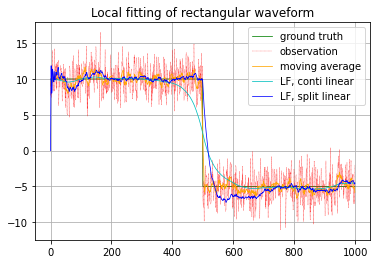

In [ ]:
plt.figure()
plt.title('Local fitting of rectangular waveform')
plt.plot(torch.arange(0, T), y_rect.squeeze(), color='green',  linewidth=0.75, label='ground truth')
plt.plot(torch.arange(0, T), y_rect_noisy.squeeze(), '--', color='red',  linewidth=0.25, label='observation')
plt.plot(torch.arange(0, T), y_rect_MA.squeeze(), color='orange', linewidth=0.75, label='moving average')
plt.plot(torch.arange(0, T), y_rect_LF_linear_model.squeeze(), color='c', linewidth=0.75, label='LF, conti linear')
plt.plot(torch.arange(0, T), y_rect_LF_split_dc_model.squeeze(), color='blue', linewidth=0.75, label='LF, split linear')
plt.legend()
plt.grid()

plt.savefig('test_local/rect_wave.pdf')
plt.show()

In [ ]:
t_range = range(100, 900)
loss_func = nn.MSELoss(reduction='mean')
torch.set_printoptions(precision=5, sci_mode=False)
y_gt = y_rect
print('MSE - Noise Floor: ', loss_func(y_gt[:, t_range], y_rect_noisy[:, t_range]))
print('MSE - Moving Avg: ', loss_func(y_gt[:, t_range], y_rect_MA[:, t_range]))
print('MSE - LF linear model: ', loss_func(y_gt[:, t_range], y_rect_LF_linear_model[:, t_range]))
print('MSE - LF split model: ', loss_func(y_gt[:, t_range], y_rect_LF_split_dc_model[:, t_range]))
# print('MSE - LF merge: ', loss_func(y_gt[:, t_range], y_LF_merge[:, t_range]))

MSE - Noise Floor:  tensor(3.88349)
MSE - Moving Avg:  tensor(0.60697)
MSE - LF linear model:  tensor(2.75412)
MSE - LF split model:  tensor(2.68757)


### Local Cost Ratio

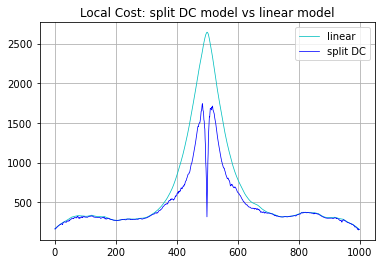

In [ ]:
c2 = split_dc_model.cost
c1 = linear_model.cost
plt.figure()
plt.title('Local Cost: split DC model vs linear model')
plt.plot(torch.arange(0, T), c1, color='c',  linewidth=0.75, label='linear')
plt.plot(torch.arange(0, T), c2, color='blue',  linewidth=0.75, label='split DC')
plt.legend()
plt.grid()

plt.show()

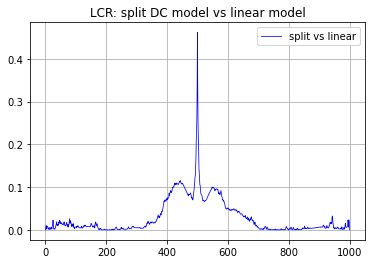

In [ ]:
lcr = LCR(split_dc_model, linear_model)
plt.figure()
plt.title('LCR: split DC model vs linear model')
# plt.plot(torch.arange(0, T), y_tri.squeeze(), color='green',  linewidth=0.75, label='ground truth')
plt.plot(torch.arange(0, T), lcr.squeeze(), color='blue',  linewidth=0.75, label='split vs linear')
plt.legend()
plt.grid()

plt.show()

# "ECG" Signal
A ECG signal consists of 7 segments inside a cylce:
1. P wave (round)
2. PR segement
3. QRS complex:
    - negative Q wave
    - positive R wave
    - negative S wave
4. ST segement
5. T wave (round)

### Generate ECG

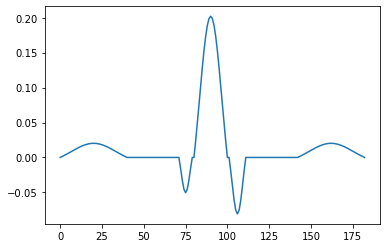

In [2]:
from torch.distributions.normal import Normal

def gen_gaussian_pulse(width, amp=1):
    ndist = Normal(torch.tensor(0), torch.tensor(width/3))
    t = torch.arange(-width/2, 1+width/2)
    gpulse = ndist.log_prob(t).exp()
    gpulse = gpulse - gpulse.min()
    gpulse *= amp
    return gpulse

p_pulse = gen_gaussian_pulse(width=40, amp=1)
pr_segm = torch.zeros(30)
q_pluse = gen_gaussian_pulse(width=8, amp=-0.5)
r_pluse = gen_gaussian_pulse(width=20, amp=5)
s_pluse = gen_gaussian_pulse(width=10, amp=-1)
st_segm = torch.zeros(30)
t_pulse = gen_gaussian_pulse(width=40, amp=1)

y_ecg = torch.cat([ p_pulse,
                    pr_segm,
                    q_pluse,
                    r_pluse,
                    s_pluse,
                    st_segm,
                    t_pulse], dim=0)

T_ecg = y_ecg.size()[-1]
plt.plot(torch.arange(0, T_ecg), y_ecg)






In [3]:
y_ecg.unsqueeze(0).size()

torch.Size([1, 183])

### Apply Local Fitting

In [4]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)

split_linear_model = LocalFitter(A, C, ExpWin_DS(), A, C)

gamma = 0.8

pm_conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

split_linear_model.fit(y_ecg.unsqueeze(0), 
                       win_param_fwd=gamma, 
                       win_param_bwd=gamma, 
                       post_mult=pm_conti_y)             

y_ecg_LF = split_linear_model.generate_signal()

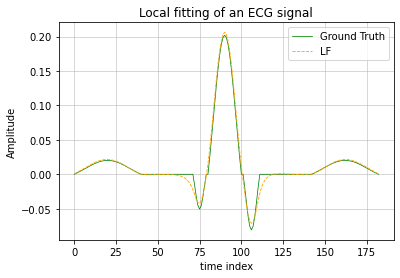

In [9]:
plt.figure()
plt.title('Local fitting of an ECG signal')
plt.xlabel('time index')
plt.ylabel('Amplitude')
plt.plot(torch.arange(0, T_ecg), y_ecg.squeeze(), color='green',  linewidth=0.75, label='Ground Truth')
plt.plot(torch.arange(0, T_ecg), y_ecg_LF.squeeze(), '--', color='orange', linewidth=0.85, label='LF')
plt.legend()
plt.grid(lw=0.5)

plt.savefig('test_local/ecg.pdf')
plt.show()

In [6]:
loss_func = nn.MSELoss(reduction='mean')
MSE_ecg = loss_func(y_ecg, y_ecg_LF)
MSE_ecg = 10*torch.log10(MSE_ecg)
print('MSE - local fitting ECG: ', MSE_ecg, '[dB]')


MSE - local fitting ECG:  tensor(-45.1723) [dB]


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 183])) that is different to the input size (torch.Size([183])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
